In [ ]:
# 1. LOAD AND PREPARE DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import math
from scipy.stats import norm




df = pd.read_csv('/content/AMKR_Spread_prediction.csv')
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Enhanced numeric conversion
for col in df.columns:
    if col != 'Date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows where target is missing
target = 'Spread_AMKR'
if target in df.columns:
    df = df[df[target].notna()].reset_index(drop=True)

print("Dataset Shape:", df.shape)
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total Quarters: {len(df)}")
print(f"\nWARNING: Small dataset detected ({len(df)} samples)")
print("Using regularized models and conservative approach...\n")


Dataset Shape: (41, 27)
Date Range: 2015-09-30 00:00:00 to 2025-09-30 00:00:00
Total Quarters: 41

Using regularized models and conservative approach...



CORRELATION ANALYSIS WITH TARGET VARIABLE

Top 15 Variables Correlated with Spread_AMKR:
 2. Return on Assets(%)_AMKR                 :  0.8020
 3. Operating_Income_AMKR                    :  0.5422
 4. Other_Manufacturing_Expenses             :  0.4803
 5. Consumer                                 :  0.4467
 6. EBITDA_Margin_AMKR                       :  0.4020
 7. Lead                                     :  0.3660
 8. Automative & Industrial                  :  0.1856
 9. Computing                                :  0.1452
10. Materials_Expenses                       :  0.1343
11. Net_Debt_AMKR                            :  0.0833
12. Communications                           :  0.0763
13. RnD_AMKR                                 :  0.0221
14. QCOM                                     : -0.0145
15. Net_Income_Growth(QoQ%)_AMKR             : -0.0712
16. AAPL                                     : -0.0774


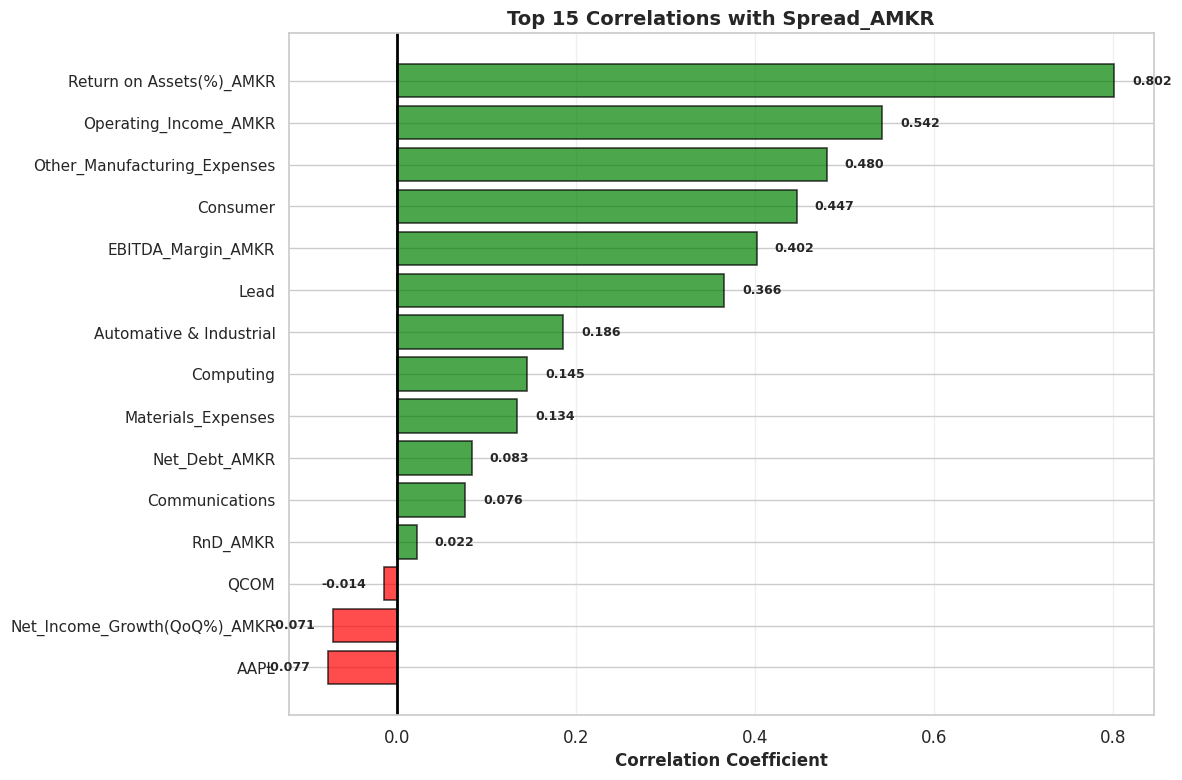


Highly Correlated Variable Pairs (|r| > 0.8):
AAPL                                ↔ Net_Debt_AMKR                       : 0.972
SOX                                 ↔ AAPL                                : 0.956
QCOM                                ↔ AAPL                                : 0.955
Communications                      ↔ Materials_Expenses                  : 0.948
QCOM                                ↔ Net_Debt_AMKR                       : 0.943
WSTS_Billings                       ↔ SOX                                 : 0.936
SOX                                 ↔ Net_Debt_AMKR                       : 0.932
SOX                                 ↔ QCOM                                : 0.924
SOX                                 ↔ Gold                                : 0.921
WSTS_Billings                       ↔ AAPL                                : 0.910
WSTS_Billings                       ↔ Computing                           : 0.904
WSTS_Billings                       ↔ Gold         

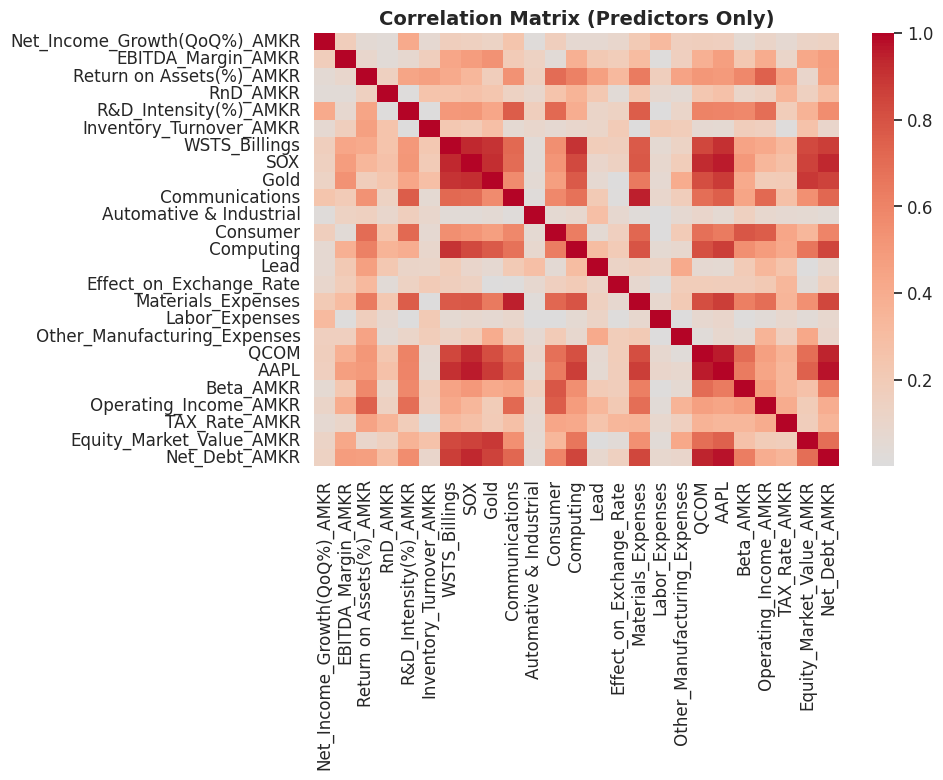

In [ ]:
# 2. CORRELATION ANALYSIS


print("="*60)
print("CORRELATION ANALYSIS WITH TARGET VARIABLE")
print("="*60)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Spread_AMKR' in numeric_cols:
    correlations = df[numeric_cols].corr()['Spread_AMKR'].sort_values(ascending=False)

    print("\nTop 15 Variables Correlated with Spread_AMKR:")
    print("="*60)
    for i, (var, corr) in enumerate(correlations.items(), 1):
        if var != 'Spread_AMKR':
            print(f"{i:2d}. {var:40s} : {corr:7.4f}")
        if i >= 16:
            break

    # Visualize correlations
    fig_corr1, ax_corr1 = plt.subplots(1, 1, figsize=(12, 8))

    top_corr = correlations[correlations.index != 'Spread_AMKR'][:15]
    colors_pos = ['green' if x > 0 else 'red' for x in top_corr]
    ax_corr1.barh(range(len(top_corr)), top_corr, color=colors_pos, alpha=0.7,
                  edgecolor='black', linewidth=1.2)
    ax_corr1.set_yticks(range(len(top_corr)))
    ax_corr1.set_yticklabels(top_corr.index, fontsize=11)
    ax_corr1.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax_corr1.set_title('Top 15 Correlations with Spread_AMKR', fontsize=14, fontweight='bold')
    ax_corr1.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax_corr1.grid(True, alpha=0.3, axis='x')
    ax_corr1.invert_yaxis()

    for i, v in enumerate(top_corr):
        ax_corr1.text(v + 0.02 if v > 0 else v - 0.02, i, f'{v:.3f}',
                     va='center', ha='left' if v > 0 else 'right',
                     fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Compute the full correlation matrix among numeric predictors (excluding target)
corr_matrix = df[numeric_cols].drop(columns=['Spread_AMKR'], errors='ignore').corr().abs()

# Flag highly correlated pairs
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            high_corr_pairs.append((var1, var2, corr_matrix.iloc[i, j]))

# Display results
print("\nHighly Correlated Variable Pairs (|r| > 0.8):")
print("=" * 60)
if high_corr_pairs:
    for v1, v2, corr_val in sorted(high_corr_pairs, key=lambda x: -x[2]):
        print(f"{v1:35s} ↔ {v2:35s} : {corr_val:.3f}")
else:
    print("No variable pairs exceed the correlation threshold of 0.8.")

# Optional visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Matrix (Predictors Only)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# 3. FEATURE ENGINEERING (for small datasets, leak-free)

def create_simple_features(data, target_col='Spread_AMKR', top_external_from_train=None):
    """Create minimal, leak-free features for small datasets."""
    df_feat = data.copy()

    # ----- Basic time features -----
    df_feat['Quarter'] = df_feat['Date'].dt.quarter
    df_feat['Quarter_Sin'] = np.sin(2 * np.pi * df_feat['Quarter'] / 4)
    df_feat['Quarter_Cos'] = np.cos(2 * np.pi * df_feat['Quarter'] / 4)

    # ----- Limited lag features -----
    for lag in [1, 4]:  # 1 quarter and 1 year
        df_feat[f'{target_col}_lag{lag}'] = df_feat[target_col].shift(lag)

    # ----- Rolling mean (trend smoothing) -----
    df_feat[f'{target_col}_rolling_mean_4'] = df_feat[target_col].rolling(window=4, min_periods=2).mean()

    # ----- Year-over-year difference -----
    df_feat[f'{target_col}_yoy_diff'] = df_feat[target_col].diff(4)

    # ----- Use TRAIN-only chosen external features (leak-free) -----
    if top_external_from_train is not None:
        for var in top_external_from_train:
            if var in df_feat.columns and var != target_col:
                df_feat[f'{var}_lag1'] = df_feat[var].shift(1)

    # (Multicollinearity pruning will be done on TRAIN ONLY later.)
    return df_feat

# ----- Run feature engineering -----
df_with_features = create_simple_features(df)
df_clean = df_with_features.dropna().reset_index(drop=True)

print(f"\nSimplified feature engineering complete:")
print(f"  Original columns: {df.shape[1]}")
print(f"  New features added: {df_clean.shape[1] - df.shape[1]}")
print(f"  Clean dataset: {df_clean.shape[0]} samples")
print(f"  Features lost due to lags: {len(df) - len(df_clean)} samples")





Simplified feature engineering complete:
  Original columns: 27
  New features added: 7
  Clean dataset: 37 samples
  Features lost due to lags: 4 samples


Notes:
1.   The function "*create_simple_features()*" is designed for small time-series data (only 40 quarters in this case).
It aims to add meaningful predictive features without creating too much noise or multicollinearity.
2. The lagged values let the model “remember” short-term and seasonal past behavior without needing a deep learning memory cell (helpful since the dataset is small).







In [ ]:
# 4. TRAIN/TEST SPLIT (Time-aware, after feature engineering)


# ---- Train/Test index ----

test_size_initial = max(3, int(len(df) * 0.44))
train_idx_initial = np.arange(0, len(df) - test_size_initial)

# Train-only correlations to pick top external drivers (no target leakage)
numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
if target in numeric_cols_all:
    train_corr = (
        df.iloc[train_idx_initial][numeric_cols_all]
        .corr()[target]
        .drop(labels=[target])
        .abs()
        .sort_values(ascending=False)
    )
    TOP_EXTERNAL_FROM_TRAIN = train_corr.head(5).index.tolist()
else:
    TOP_EXTERNAL_FROM_TRAIN = []

print("Top external features (from TRAIN only):", TOP_EXTERNAL_FROM_TRAIN)

exclude_cols = ['Date', target]
all_features = [c for c in df_clean.columns if c not in exclude_cols]
exclude_cols = ['Date', target]
all_features = [c for c in df_clean.columns if c not in exclude_cols]

# Recompute split on df_clean length
test_size = max(3, int(len(df_clean) * 0.44))
train_size = len(df_clean) - test_size
train_idx = np.arange(0, train_size)
test_idx  = np.arange(train_size, len(df_clean))

# --- Multicollinearity pruning on TRAIN only ---
train_feat_df = df_clean.iloc[train_idx][all_features]
corr_mat = train_feat_df.corr().abs()
thr = 0.85

# Whitelist: variables that must be kept even if correlated
whitelist = {'Materials_Expenses','Net_Debt_AMKR','Consumer','Beta_AMKR'}

to_drop = set()
dropped_pairs = []  # (kept_var, dropped_var, corr_value)
cols = list(corr_mat.columns)

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        corr_val = corr_mat.iloc[i, j]
        if corr_val > thr:
            keep_var = cols[i]
            drop_var = cols[j]

            # Skip if either variable is protected
            if keep_var in whitelist or drop_var in whitelist:
                continue

            if drop_var not in to_drop:
                to_drop.add(drop_var)
                dropped_pairs.append((keep_var, drop_var, float(corr_val)))

pruned_features = [c for c in all_features if c not in to_drop]

# --- Print results ---
print(f"Pruned {len(to_drop)} highly correlated features (|r| > {thr}).")
if to_drop:
    print("Dropped variables:", ", ".join(sorted(to_drop)))
    print("\nExamples of triggering pairs (kept → dropped : corr):")
    for keep_var, drop_var, corr_val in sorted(dropped_pairs, key=lambda x: -x[2])[:10]:
        print(f"  {keep_var}  →  {drop_var}  :  {corr_val:.3f}")
else:
    print("No features were pruned above the correlation threshold.")

X = df_clean[pruned_features]
y = df_clean[target]

X_train = X.iloc[train_idx]
X_test  = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

print(f"\nTrain/Test Split :")
print(f"  Training: {len(X_train)} samples")
print(f"  Testing:  {len(X_test)} samples")
print(f"  Total:    {len(df_clean)} samples")


Top external features (from TRAIN only): ['Return on Assets(%)_AMKR', 'Computing', 'WSTS_Billings', 'Operating_Income_AMKR', 'Net_Debt_AMKR']
Pruned 3 highly correlated features (|r| > 0.85).
Dropped variables: AAPL, QCOM, Spread_AMKR_rolling_mean_4

Examples of triggering pairs (kept → dropped : corr):
  SOX  →  AAPL  :  0.982
  SOX  →  QCOM  :  0.953
  Spread_AMKR_lag1  →  Spread_AMKR_rolling_mean_4  :  0.932

Train/Test Split :
  Training: 21 samples
  Testing:  16 samples
  Total:    37 samples


Note:

*   This ratio was chosen empirically (“0.44”) — it balances two competing needs:

 Enough training data for the model to learn meaningful patterns. A long enough testing horizon to evaluate whether the model captures cyclical patterns and turning points across multiple market conditions.




In [ ]:
# 5. ENSEMBLE OF SIMPLE MODELS (Regularized for small data)


print("\n" + "="*60)
print("TRAINING ENSEMBLE OF REGULARIZED MODELS (TS-CV + SAFE XGB)")
print("="*60)

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# --- Standardize features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Time-series CV setup ---
tscv = TimeSeriesSplit(n_splits=5)

# --- Regularized linear models (auto-tuned) ---
ridge_model = RidgeCV(alphas=np.logspace(-3, 3, 25), cv=tscv).fit(X_train_scaled, y_train)
lasso_model = LassoCV(alphas=np.logspace(-3, 1, 25), cv=tscv, max_iter=10000).fit(X_train_scaled, y_train)
elastic_model = ElasticNetCV(l1_ratio=[.2, .4, .6, .8],
                             alphas=np.logspace(-3, 1, 20),
                             cv=tscv, max_iter=10000).fit(X_train_scaled, y_train)

print(f"Ridge alpha:   {ridge_model.alpha_ if hasattr(ridge_model, 'alpha_') else 'n/a'}")
print(f"Lasso alpha:   {lasso_model.alpha_}")
print(f"Elastic best:  alpha={elastic_model.alpha_}, l1_ratio={elastic_model.l1_ratio_}")

# --- Conservative XGBoost (version-agnostic) ---
val_size = max(2, int(0.2 * len(X_train)))
X_tr_es, X_val_es = X_train.iloc[:-val_size], X_train.iloc[-val_size:]
y_tr_es, y_val_es = y_train.iloc[:-val_size], y_train.iloc[-val_size:]

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=6,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1.0,
    reg_lambda=2.0,
    gamma=1.0,
    random_state=42
)

try:
    # Preferred API (newer XGBoost)
    xgb_model.fit(
        X_tr_es, y_tr_es,
        eval_set=[(X_val_es, y_val_es)],
        early_stopping_rounds=50,
        verbose=False
    )
except TypeError:
    # Older versions without early_stopping_rounds
    try:
        xgb_model.fit(
            X_tr_es, y_tr_es,
            eval_set=[(X_val_es, y_val_es)],
            verbose=False
        )
    except TypeError:
        # Very old: plain training, smaller capacity
        try:
            xgb_model.set_params(n_estimators=300, learning_rate=0.05, max_depth=3)
            xgb_model.fit(X_tr_es, y_tr_es)
        except Exception as e:
            # Final fallback to RandomForest
            print("XGBoost incompatible, using RandomForest fallback:", e)
            xgb_model = RandomForestRegressor(
                n_estimators=300, max_depth=3, min_samples_leaf=4, random_state=42
            )
            xgb_model.fit(X_tr_es, y_tr_es)

# --- Predictions ---
y_train_pred_ridge   = ridge_model.predict(X_train_scaled)
y_train_pred_lasso   = lasso_model.predict(X_train_scaled)
y_train_pred_elastic = elastic_model.predict(X_train_scaled)
y_train_pred_xgb     = xgb_model.predict(X_train)

y_test_pred_ridge    = ridge_model.predict(X_test_scaled)
y_test_pred_lasso    = lasso_model.predict(X_test_scaled)
y_test_pred_elastic  = elastic_model.predict(X_test_scaled)
y_test_pred_xgb      = xgb_model.predict(X_test)

# Ensemble (same weights as your original):
y_train_pred = (y_train_pred_ridge*0.1 + y_train_pred_lasso*0.8 +
                y_train_pred_elastic*0.1 + y_train_pred_xgb*0)
y_test_pred = (y_test_pred_ridge*0.1 + y_test_pred_lasso*0.8 +
               y_test_pred_elastic*0.1 + y_test_pred_xgb*0)




TRAINING ENSEMBLE OF REGULARIZED MODELS (TS-CV + SAFE XGB)
Ridge alpha:   1.7782794100389228
Lasso alpha:   0.001
Elastic best:  alpha=0.001, l1_ratio=0.8



MODEL PERFORMANCE METRICS

Training Set:
  RMSE: 0.0425
  MAE:  0.0328
  R²:   0.9997

Test Set (Primary Metrics):
  RMSE: 1.4777 <- Key metric for small datasets
  MAE:  1.1383 <- More robust to outliers
  Directional Accuracy: 93.3% <- Did we predict up/down correctly?
  R²:   0.9215 (less reliable with small test set)

Individual Model Performance (Test MAE):
  Ridge:      3.6095
  Lasso:      0.7783
  ElasticNet: 1.7595
  XGB/RF:     4.1575
  Ensemble:   1.1383


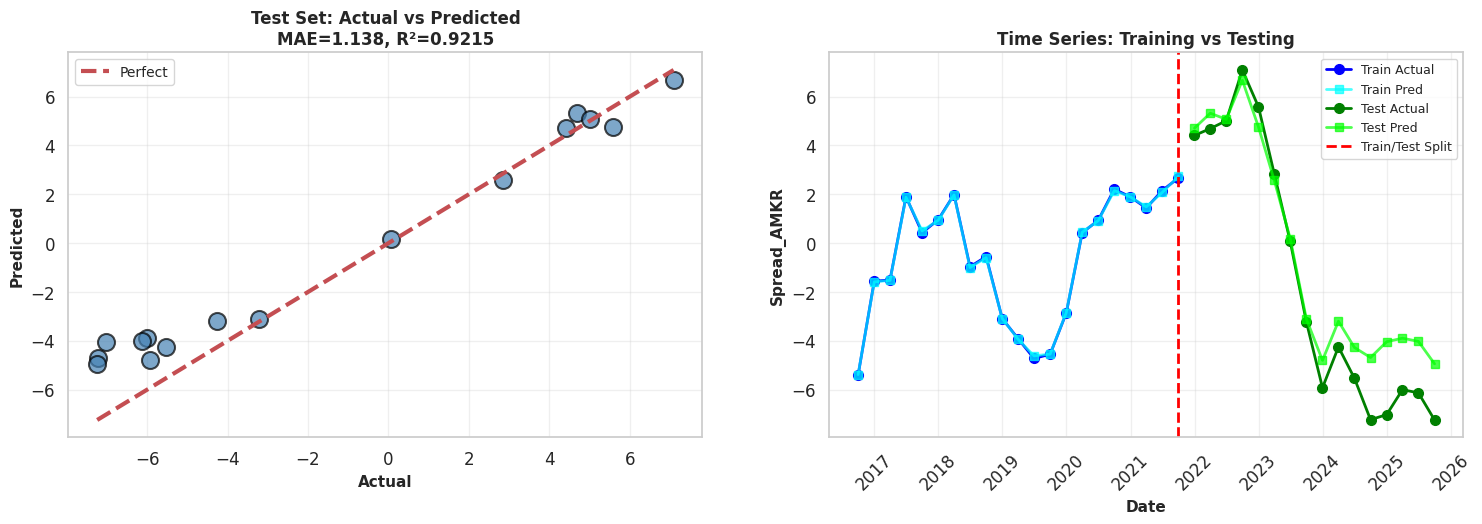

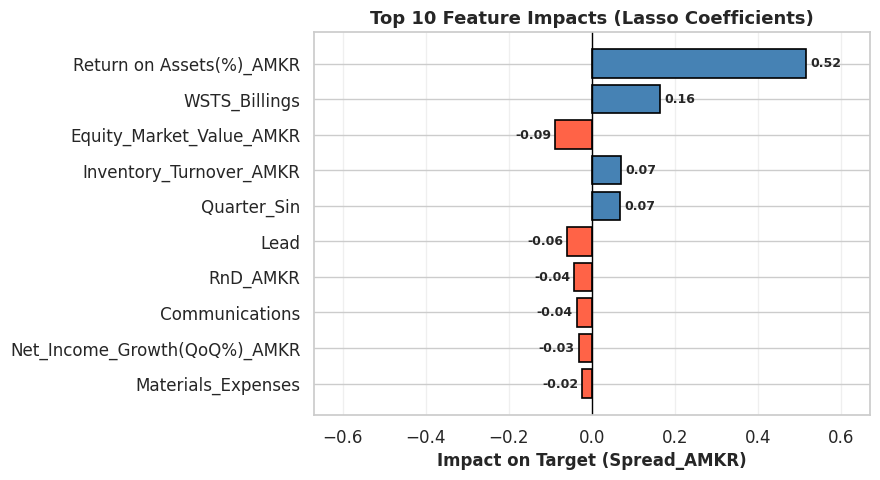

In [ ]:
# 6. MODEL EVALUATION (Focus on MAE, RMSE, Directional Accuracy)

print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

# Training metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Directional accuracy (did we predict the right direction?)
if len(y_test) > 1:
    actual_direction = np.sign(np.diff(y_test.values))
    pred_direction = np.sign(np.diff(y_test_pred))
    directional_accuracy = np.mean(actual_direction == pred_direction) * 100
else:
    directional_accuracy = None

print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")

print(f"\nTest Set (Primary Metrics):")
print(f"  RMSE: {test_rmse:.4f} <- Key metric for small datasets")
print(f"  MAE:  {test_mae:.4f} <- More robust to outliers")
if directional_accuracy is not None:
    print(f"  Directional Accuracy: {directional_accuracy:.1f}% <- Did we predict up/down correctly?")
print(f"  R²:   {test_r2:.4f} (less reliable with small test set)")

# Model comparison
print(f"\nIndividual Model Performance (Test MAE):")
print(f"  Ridge:      {mean_absolute_error(y_test, y_test_pred_ridge):.4f}")
print(f"  Lasso:      {mean_absolute_error(y_test, y_test_pred_lasso):.4f}")
print(f"  ElasticNet: {mean_absolute_error(y_test, y_test_pred_elastic):.4f}")
print(f"  XGB/RF:     {mean_absolute_error(y_test, y_test_pred_xgb):.4f}")
print(f"  Ensemble:   {test_mae:.4f}")

# Diagnostic plots (simplified)
fig_diag, axes_diag = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Actual vs Predicted
ax1 = axes_diag[0]
ax1.scatter(y_test, y_test_pred, alpha=0.7, s=150, edgecolors='black',
            linewidths=1.5, color='steelblue')
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3, label='Perfect')
ax1.set_xlabel('Actual', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted', fontsize=11, fontweight='bold')
ax1.set_title(f'Test Set: Actual vs Predicted\nMAE={test_mae:.3f}, R²={test_r2:.4f}',
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Time series comparison
ax2 = axes_diag[1]
all_dates = df_clean['Date']
ax2.plot(all_dates[:train_size], y_train, 'o-', label='Train Actual',
         linewidth=2, markersize=7, color='blue')
ax2.plot(all_dates[:train_size], y_train_pred, 's-', label='Train Pred',
         linewidth=2, markersize=6, color='cyan', alpha=0.7)
ax2.plot(all_dates[train_size:], y_test, 'o-', label='Test Actual',
         linewidth=2, markersize=7, color='green')
ax2.plot(all_dates[train_size:], y_test_pred, 's-', label='Test Pred',
         linewidth=2, markersize=6, color='lime', alpha=0.7)
ax2.axvline(x=all_dates.iloc[train_size-1], color='red', linestyle='--',
            linewidth=2, label='Train/Test Split')
ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_ylabel('Spread_AMKR', fontsize=11, fontweight='bold')
ax2.set_title('Time Series: Training vs Testing', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9, loc='best')
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Plot 3: Feature importance with direction (positive/negative)

# Use Lasso coefficients to preserve sign
feature_names = list(X.columns)
lasso_coefs = getattr(lasso_model, "coef_", None)

if lasso_coefs is not None and len(lasso_coefs) == len(feature_names):
    imp_vals = np.array(lasso_coefs, dtype=float)
    source = "Lasso Coefficients"
else:
    imp_vals = getattr(xgb_model, "feature_importances_", None)
    if imp_vals is not None and len(imp_vals) == len(feature_names):
        imp_vals = np.array(imp_vals, dtype=float)
        source = "XGB Importance"
    else:
        imp_vals = np.zeros(len(feature_names))
        source = "N/A"

#Build DataFrame
fi = pd.DataFrame({"Feature": feature_names, "Importance": imp_vals})
fi = fi[~fi["Feature"].str.contains("Spread", case=False, na=False)]

#Top 10 by absolute value
fi_top = fi.reindex(fi["Importance"].abs().sort_values(ascending=False).index).head(10)

#Colors: blue positive, red negative
colors = ["steelblue" if v > 0 else "tomato" for v in fi_top["Importance"]]

plt.figure(figsize=(9, 5))
ax = plt.gca()
bars = ax.barh(fi_top["Feature"], fi_top["Importance"],
               color=colors, edgecolor="black", linewidth=1.2)

#Add all labels outside the bars
max_abs = max(1e-6, float(np.max(np.abs(fi_top["Importance"]))))
pad = 0.02 * max_abs

for bar, val in zip(bars, fi_top["Importance"]):
    x = val + np.sign(val) * pad
    ha = "left" if val > 0 else "right"
    ax.text(x,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.2f}",
            va="center", ha=ha, fontsize=9, fontweight="bold")

#Styling
ax.set_xlabel("Impact on Target (Spread_AMKR)", fontsize=12, fontweight="bold")
ax.set_title(f"Top {len(fi_top)} Feature Impacts ({source})", fontsize=13, fontweight="bold")
ax.axvline(0, color="black", linewidth=1)
ax.grid(True, alpha=0.3, axis="x")
ax.invert_yaxis()
ax.set_xlim(-max_abs * 1.3, max_abs * 1.3)  # add headroom both sides

plt.tight_layout()
plt.show()

Note:


*   Originally, we assumed that XGBoost would perform the best, since it usually works well for non-linear prediction tasks. However, the model testing results indicate that Lasso performs the best. We suspect this is because the test period we selected mainly shows a steady downward trend with fewer ups and downs, so linear models like Lasso perform better in this context.
*   If you look at the period after 2024 in the training vs. testing plot, you can see that the model tends to be more optimistic than the actual performance. This happens because the trend starting from 2024 is at an all-time low. Therefore, it is normal for the model to be optimistic: it is learning from previous data, so it tends to be less accurate when the trend breaks past records and moves into unseen territory.





In [ ]:
# 7. ARIMA/SARIMAX HYBRID FORECAST (Best for small cyclical data)

print("\n" + "="*60)
print("ARIMA HYBRID FORECASTING")
print("="*60)

try:
    #Fit SARIMAX model
    sarimax_model = SARIMAX(
        df_clean[target],
        order=(2, 0, 2),
        seasonal_order=(1, 0, 1, 4),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    sarimax_fit = sarimax_model.fit(disp=False, maxiter=300)
    print("CHECK: SARIMAX model fitted successfully")

    #Forecast 10 quarters =
    n_forecast = 10
    sarimax_fc_obj = sarimax_fit.get_forecast(steps=n_forecast)
    sarimax_mean = sarimax_fc_obj.predicted_mean.values
    sarimax_conf_int = sarimax_fc_obj.conf_int()

    #Detrend history for cycles
    from scipy.signal import detrend

    hist_vals = df_clean[target].values.astype(float)
    detrended = detrend(hist_vals)
    historical_volatility = float(np.std(detrended))

    #FFT cycles (mild amplitude)
    fft_vals = fft(detrended)
    freqs = fftfreq(len(detrended), d=1.0)
    mags = np.abs(fft_vals)
    top_idx = np.argsort(mags[1:len(mags)//2])[-3:] + 1

    cyc_adj = []
    N0 = len(hist_vals)
    for h in range(n_forecast):
        s = 0.0
        for k in top_idx:
            amp = mags[k] / len(detrended) * 1.0
            phase = np.angle(fft_vals[k])
            s += amp * np.cos(2*np.pi*freqs[k]*(N0 + h) + phase)
        s = np.clip(s, -np.std(detrended), np.std(detrended))
        cyc_adj.append(s)
    cyc_adj = np.array(cyc_adj, dtype=float)

    #Recursive ensemble forecast
    last_features = X.iloc[[-1]].copy()
    last_scaled = scaler.transform(last_features)
    ens = []
    recent = list(hist_vals[-4:])

    for i in range(n_forecast):
        pr_ridge = ridge_model.predict(last_scaled)[0]
        pr_lasso = lasso_model.predict(last_scaled)[0]
        pr_elnet = elastic_model.predict(last_scaled)[0]
        pr_xgb   = xgb_model.predict(last_features.values)[0]
        pred_avg = ( 0.1* pr_ridge + 0.8* pr_lasso + 0.1 * pr_elnet + 0.0* pr_xgb)

        if len(recent) >= 2:
            pred_avg += 0.1 * (recent[-1] - recent[-2])  # calmer momentum

        ens.append(pred_avg)
        recent.append(pred_avg)

        if f'{target}_lag1' in last_features.columns:
            last_features[f'{target}_lag1'] = pred_avg
        if f'{target}_lag4' in last_features.columns and i >= 3:
            last_features[f'{target}_lag4'] = ens[i-3]
        if f'{target}_rolling_mean_4' in last_features.columns:
            last_features[f'{target}_rolling_mean_4'] = np.mean(ens[max(0, i-3):i+1])

        last_scaled = scaler.transform(last_features)

    ens = np.array(ens, dtype=float)

    #Hybrid mean
    hybrid_forecast = 0.4 * sarimax_mean + 0.4 * ens + 0.2 * cyc_adj

    #Forecast dates
    last_date = df_clean['Date'].iloc[-1]
    forecast_dates = pd.date_range(start=last_date, periods=n_forecast+1, freq='Q')[1:]

    #95% CI centered on hybrid forecast
    from scipy.stats import t as student_t

    # 1) Convert SARIMAX CI to sigma
    sarimax_sigma = (sarimax_conf_int.iloc[:, 1].values -
                     sarimax_conf_int.iloc[:, 0].values) / (2.0 * 1.96)

    # 2) Ensemble sigma: residual std if available
    if ('y_test' in globals() and 'y_test_pred' in globals()
        and len(y_test) == len(y_test_pred) and not np.all(np.isnan(y_test_pred))):
        ens_sigma_1step = float(np.nanstd(np.array(y_test) - np.array(y_test_pred)))
    else:
        ens_sigma_1step = float(np.std(detrended))

    h = np.arange(1, n_forecast+1, dtype=float)
    ensemble_sigma = ens_sigma_1step * np.sqrt(h)
    cycle_sigma = np.full(n_forecast, 0.25 * historical_volatility, dtype=float)

    # 3) Combine under weights
    w1, w2, w3 = 0.4, 0.4, 0.2
    hybrid_sigma = np.sqrt((w1*sarimax_sigma)**2 +
                           (w2*ensemble_sigma)**2 +
                           (w3*cycle_sigma)**2)

    #Patch A: Inflate sigma using recent residuals
    recent_k = min(8, len(y_test)) if 'y_test' in globals() else 0
    if recent_k >= 2:
        recent_resid = np.array(y_test[-recent_k:]) - np.array(y_test_pred[-recent_k:])
        recent_scale = np.nanstd(recent_resid)
    else:
        recent_scale = float(np.std(detrended))
    if not np.isfinite(recent_scale) or recent_scale <= 0:
        recent_scale = float(np.std(detrended))
    safety_mult = 1.25
    hybrid_sigma = np.maximum(hybrid_sigma, safety_mult * recent_scale * np.sqrt(h))

    #Patch B: Use Student-t instead of normal
    df_t = max(3, int(len(y_test) - 1)) if 'y_test' in globals() else 8
    t975 = float(student_t.ppf(0.975, df_t))  # heavier tail than 1.96

    lower_bounds = hybrid_forecast - t975 * hybrid_sigma
    upper_bounds = hybrid_forecast + t975 * hybrid_sigma

    print("CHECK: Hybrid forecast generated with heavier-tailed 95% CI (A+B)")
    print(f"  Historical volatility: {historical_volatility:.4f}")
    print(f"  Forecast volatility (Δ hybrid): {np.std(np.diff(hybrid_forecast)):.4f}")

except Exception as e:
    print(f"WARNING: SARIMAX failed ({e}); using ensemble fallback")

    n_forecast = 10
    from scipy.signal import detrend
    hist_vals = df_clean[target].values.astype(float)
    detrended = detrend(hist_vals)
    historical_std = float(np.std(detrended)) if len(detrended) > 1 else 0.01

    fft_vals = fft(detrended)
    freqs = fftfreq(len(detrended), d=1.0)
    mags = np.abs(fft_vals)
    top_idx = np.argsort(mags[1:len(mags)//2])[-3:] + 1

    last_features = X.iloc[[-1]].copy()
    last_scaled = scaler.transform(last_features)
    preds = []
    recent = list(hist_vals[-4:])

    for i in range(n_forecast):
        pr_ridge = ridge_model.predict(last_scaled)[0]
        pr_lasso = lasso_model.predict(last_scaled)[0]
        pr_elnet = elastic_model.predict(last_scaled)[0]
        pr_xgb   = xgb_model.predict(last_features.values)[0]
        pred_avg = (pr_ridge + pr_lasso + pr_elnet + pr_xgb) / 4.0
        if len(recent) >= 2:
            pred_avg += 0.1 * (recent[-1] - recent[-2])
        cyc = 0.0
        for k in top_idx:
            amp = mags[k] / len(detrended) * 1.0
            phase = np.angle(fft_vals[k])
            cyc += amp * np.cos(2*np.pi*freqs[k]*(len(hist_vals) + i) + phase)
        cyc = np.clip(cyc, -np.std(detrended), np.std(detrended))
        final_pred = pred_avg + 0.3 * cyc
        preds.append(final_pred)
        recent.append(final_pred)
        if f'{target}_lag1' in last_features.columns:
            last_features[f'{target}_lag1'] = final_pred
        if f'{target}_lag4' in last_features.columns and i >= 3:
            last_features[f'{target}_lag4'] = preds[i-3]
        last_scaled = scaler.transform(last_features)

    hybrid_forecast = np.array(preds, dtype=float)
    last_date = df_clean['Date'].iloc[-1]
    forecast_dates = pd.date_range(start=last_date, periods=n_forecast+1, freq='Q')[1:]

    h = np.arange(1, n_forecast+1, dtype=float)
    lower_bounds = hybrid_forecast - 1.96 * historical_std * np.sqrt(h)
    upper_bounds = hybrid_forecast + 1.96 * historical_std * np.sqrt(h)



ARIMA HYBRID FORECASTING
CHECK: SARIMAX model fitted successfully
CHECK: Hybrid forecast generated with heavier-tailed 95% CI (A+B)
  Historical volatility: 3.8728
  Forecast volatility (Δ hybrid): 0.3573


/tmp/ipython-input-2451018553.py:85: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_dates = pd.date_range(start=last_date, periods=n_forecast+1, freq='Q')[1:]



EVALUATION & VISUALIZATION (Integrated)

MODEL PERFORMANCE METRICS (Test Set)
RMSE:  1.4777
MAE:   1.1383
MSE:   2.1836
MAPE:  29.31602801009775
R²:    0.9215
Adj R²: 1.0841225263989305
Max Error: 2.9827
Mean Residual: -0.9487
Std Residuals: 1.1330

Prediction Accuracy:
  Within 10%: 31.2%
  Within 20%: 50.0%
  Within 30%: 62.5%

Model Quality Assessment:
  Excellent fit (R² > 0.9)

Statistical Tests:
  Shapiro-Wilk: W=0.9451, p=0.4163
    Residuals appear normally distributed (p > 0.05)
  Durbin-Watson: 0.1428
    Potential autocorrelation detected
Using 'hybrid_forecast' (from ARIMA/SARIMAX hybrid block).

ZERO CROSSING ANALYSIS
Optimistic scenario crosses above 0 around 2027-12
Base scenario: No zero crossing within 10 quarters
Pessimistic scenario: No zero crossing within 10 quarters


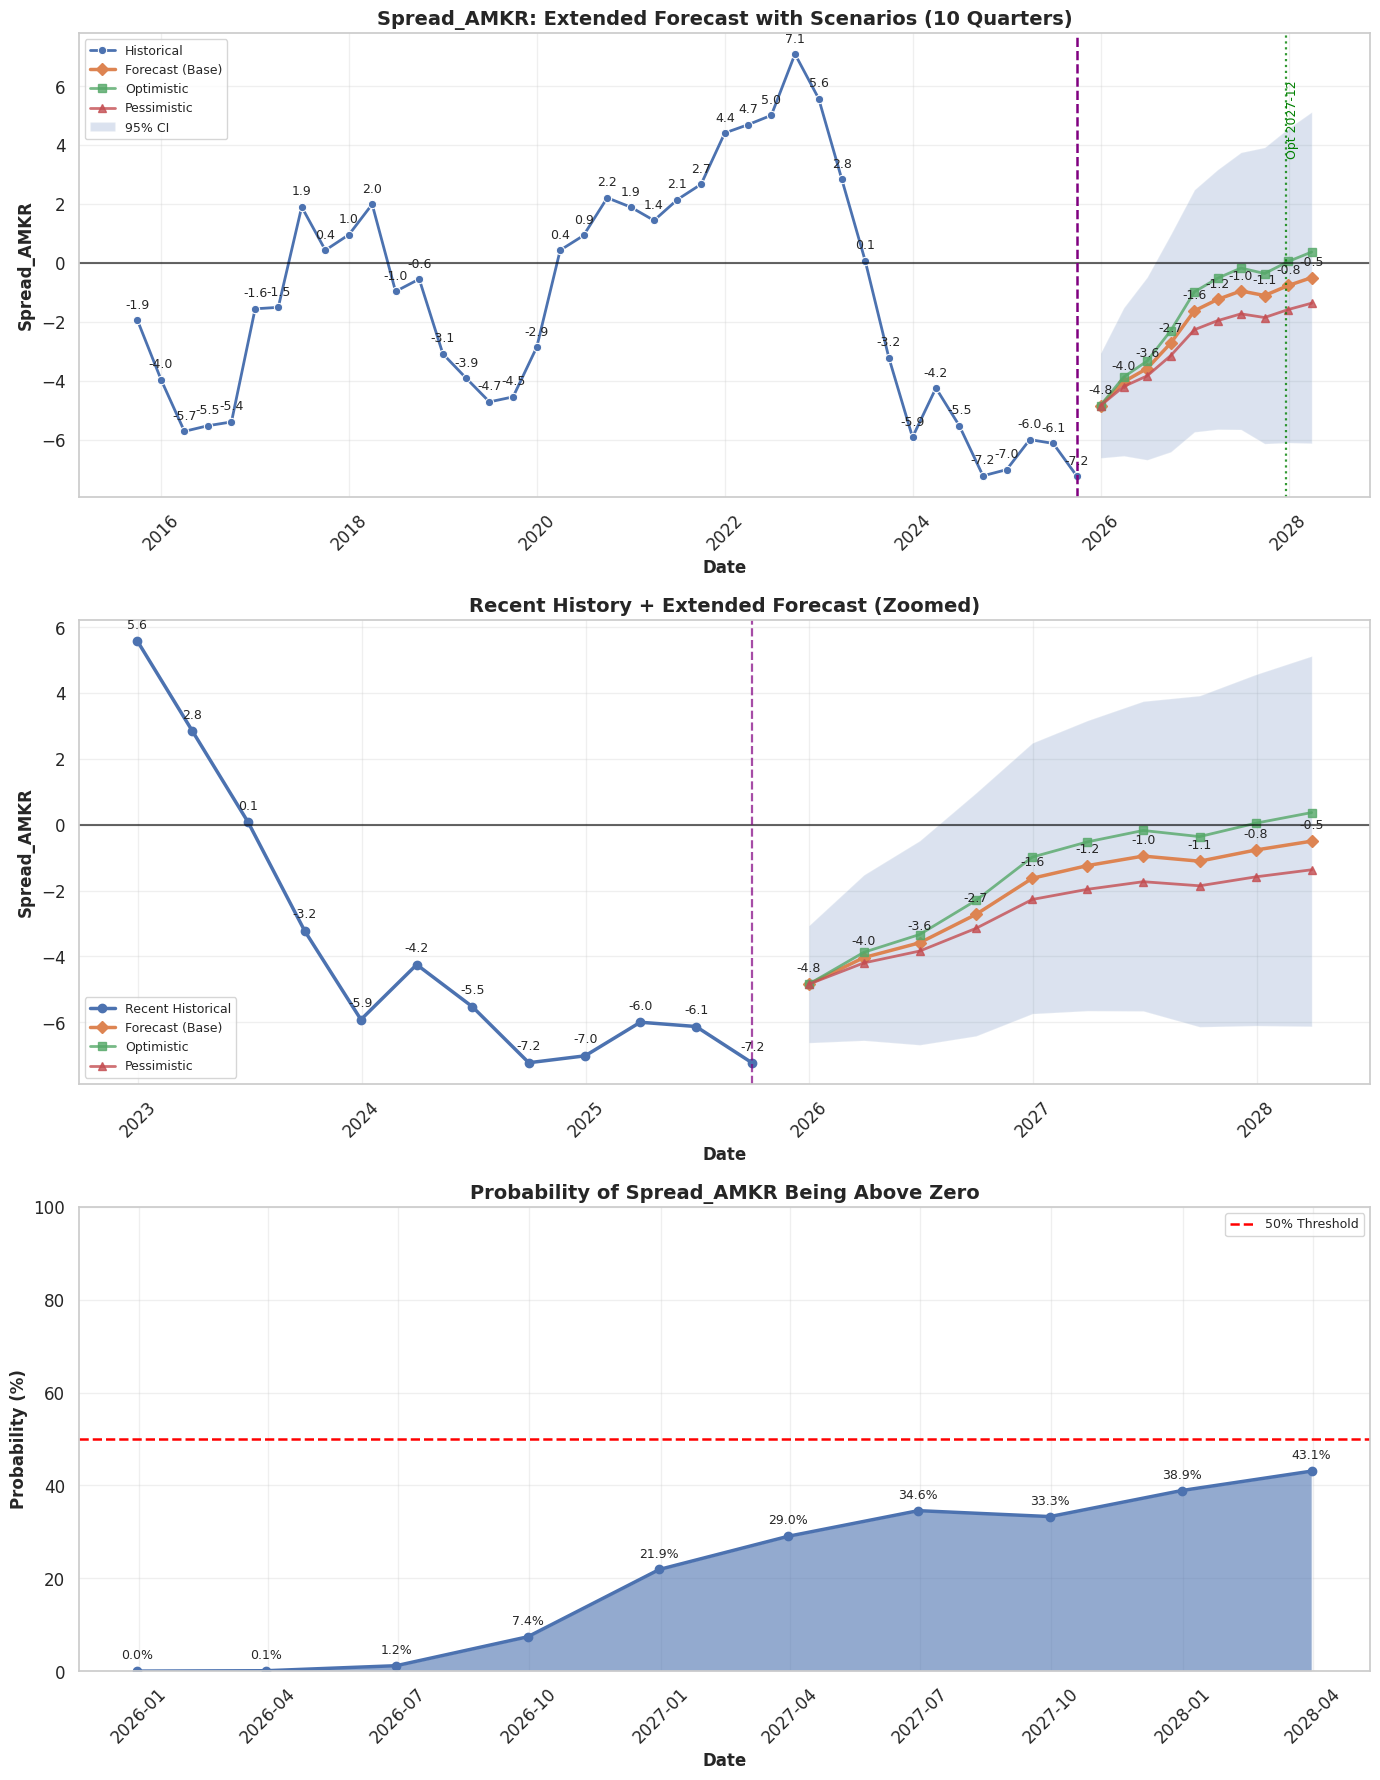

In [ ]:
# 8.EVALUATION & ROBUST VISUALIZATION


# 8.1 Use existing test predictions if available, otherwise try to compute a safe ensemble prediction
print("\n" + "="*60)
print("EVALUATION & VISUALIZATION (Integrated)")
print("="*60)

# Ensure y_test and y_test_pred exist
if 'y_test' not in globals():
    raise RuntimeError("y_test not found — make sure the Train/Test split ran before this block.")

# If y_test_pred exists (ensemble earlier), use it; otherwise try to construct from individual model preds
if 'y_test_pred' not in globals() or len(y_test_pred) != len(y_test):
    try:
        # attempt to reconstruct using same ensemble approach used earlier
        y_test_scaled = scaler.transform(X_test) if 'scaler' in globals() else X_test.values
        y_test_pred_ridge = ridge_model.predict(y_test_scaled) if 'ridge_model' in globals() else np.full(len(y_test), np.nan)
        y_test_pred_lasso = lasso_model.predict(y_test_scaled) if 'lasso_model' in globals() else np.full(len(y_test), np.nan)
        y_test_pred_elastic = elastic_model.predict(y_test_scaled) if 'elastic_model' in globals() else np.full(len(y_test), np.nan)
        y_test_pred_xgb = xgb_model.predict(X_test) if 'xgb_model' in globals() else np.full(len(y_test), np.nan)
        y_test_pred = (np.array(y_test_pred_ridge) + np.array(y_test_pred_lasso) +
                       np.array(y_test_pred_elastic) + np.array(y_test_pred_xgb)) / 4.0
        print("Reconstructed y_test_pred from available models.")
    except Exception as e:
        # last-resort: fill with NaNs so evaluation prints the fallback message
        y_test_pred = np.array([np.nan]*len(y_test))
        print(f"Could not reconstruct y_test_pred automatically ({e}).")

# Trim to equal length if necessary
y_test_arr = np.array(y_test)
if len(y_test_pred) != len(y_test_arr):
    min_len = min(len(y_test_pred), len(y_test_arr))
    y_test_eval = y_test_arr[:min_len]
    y_test_pred = np.array(y_test_pred)[:min_len]
else:
    y_test_eval = y_test_arr

# Evaluate if we have at least one prediction
if len(y_test_pred) > 0 and not np.all(np.isnan(y_test_pred)):
    residuals = y_test_eval - y_test_pred
    # Metrics
    test_rmse = np.sqrt(mean_squared_error(y_test_eval, y_test_pred))
    test_mae = mean_absolute_error(y_test_eval, y_test_pred)
    test_r2 = r2_score(y_test_eval, y_test_pred)
    # MAPE
    with np.errstate(divide='ignore', invalid='ignore'):
        test_mape = np.mean(np.abs((y_test_eval - y_test_pred) /
                                   np.where(y_test_eval==0, np.nan, y_test_eval))) * 100
    mse = mean_squared_error(y_test_eval, y_test_pred)

    print("\n" + "="*60)
    print("MODEL PERFORMANCE METRICS (Test Set)")
    print("="*60)
    print(f"RMSE:  {test_rmse:.4f}")
    print(f"MAE:   {test_mae:.4f}")
    print(f"MSE:   {mse:.4f}")
    print(f"MAPE:  {test_mape if not np.isnan(test_mape) else 'NaN'}")
    print(f"R²:    {test_r2:.4f}")
    # Adjusted R2
    n = len(y_test_eval)
    p = X_test.shape[1] if 'X_test' in globals() else 1
    if n - p - 1 != 0:
        adj_r2 = 1 - (1-test_r2)*(n-1)/(n-p-1)
    else:
        adj_r2 = np.nan
    print(f"Adj R²: {adj_r2 if not np.isnan(adj_r2) else 'NaN'}")
    print(f"Max Error: {np.max(np.abs(residuals)):.4f}")
    print(f"Mean Residual: {np.mean(residuals):.4f}")
    print(f"Std Residuals: {np.std(residuals):.4f}")

    # Prediction accuracy breakdown
    with np.errstate(divide='ignore', invalid='ignore'):
        pct_errors = np.abs((y_test_eval - y_test_pred) /
                            np.where(y_test_eval==0, np.nan, y_test_eval))
    within_10pct = np.nanmean(pct_errors < 0.10) * 100
    within_20pct = np.nanmean(pct_errors < 0.20) * 100
    within_30pct = np.nanmean(pct_errors < 0.30) * 100

    print("\nPrediction Accuracy:")
    print(f"  Within 10%: {within_10pct:.1f}%")
    print(f"  Within 20%: {within_20pct:.1f}%")
    print(f"  Within 30%: {within_30pct:.1f}%")

    # Model quality assessment
    print("\nModel Quality Assessment:")
    if test_r2 > 0.9:
        print("  Excellent fit (R² > 0.9)")
    elif test_r2 > 0.7:
        print("  Good fit (R² > 0.7)")
    elif test_r2 > 0.5:
        print("  Moderate fit (R² > 0.5)")
    else:
        print("  Weak fit (R² < 0.5) - Consider more features/data")

    # Statistical tests
    print("\nStatistical Tests:")
    if len(residuals) >= 3 and not np.allclose(residuals, residuals[0]):
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        print(f"  Shapiro-Wilk: W={shapiro_stat:.4f}, p={shapiro_p:.4f}")
        if shapiro_p > 0.05:
            print("    Residuals appear normally distributed (p > 0.05)")
        else:
            print("    Residuals may NOT be normally distributed (p < 0.05)")
    else:
        print("  Shapiro-Wilk: Skipped (need >=3 non-constant residuals)")

    try:
        dw_stat = durbin_watson(residuals)
        print(f"  Durbin-Watson: {dw_stat:.4f}")
        if 1.5 < dw_stat < 2.5:
            print("    No significant autocorrelation (1.5 < DW < 2.5)")
        else:
            print("    Potential autocorrelation detected")
    except Exception as e:
        print("  Durbin-Watson: Could not compute:", e)
else:
    print("\nInsufficient / missing test predictions for evaluation")

# 8.2 FORECAST: Try to use forecast_hybrid / hybrid_forecast, otherwise build fallback recursive ensemble forecast
n_forecast_quarters = 10

# Helper to build recursive ensemble forecast (uses trained models + scaler + last row of X)
def recursive_ensemble_forecast(n_steps, last_features_row):
    preds = []
    last_features = last_features_row.copy()
    # if scaler exists, scaler.transform will be used when feeding models that expect scaled features
    for i in range(n_steps):
        # Prepare scaled/unscaled inputs
        try:
            last_scaled = scaler.transform(last_features)
        except Exception:
            last_scaled = last_features.values  # fallback

        # predict with available models (guard with try)
        pr = []
        try:
            pr.append(ridge_model.predict(last_scaled)[0])
        except Exception:
            pr.append(np.nan)
        try:
            pr.append(lasso_model.predict(last_scaled)[0])
        except Exception:
            pr.append(np.nan)
        try:
            pr.append(elastic_model.predict(last_scaled)[0])
        except Exception:
            pr.append(np.nan)
        try:
            pr.append(xgb_model.predict(last_features.values)[0])
        except Exception:
            pr.append(np.nan)

        # average ignoring NaNs
        pr = np.array(pr, dtype=float)
        if np.all(np.isnan(pr)):
            next_pred = np.nan
        else:
            next_pred = np.nanmean(pr)

        preds.append(next_pred)

        # update lag features if exist
        if 'Spread_AMKR_lag1' in last_features.columns:
            last_features['Spread_AMKR_lag1'] = next_pred
        if 'Spread_AMKR_lag4' in last_features.columns:
            # shift previous 3 predictions into lag4 when available (best-effort)
            prev4 = preds[-4] if len(preds) >= 4 else last_features.get('Spread_AMKR_lag4', next_pred)
            last_features['Spread_AMKR_lag4'] = prev4
        if 'Spread_AMKR_rolling_mean_4' in last_features.columns:
            last_features['Spread_AMKR_rolling_mean_4'] = np.nanmean(preds[-4:]) if len(preds) > 0 else last_features.get('Spread_AMKR_rolling_mean_4', next_pred)

    return np.array(preds, dtype=float)

# Decide which forecast to use
if 'predictions' in globals() and 'lower_bounds' in globals() and 'upper_bounds' in globals():
    base_predictions = np.array(predictions)
    lb = np.array(lower_bounds)
    ub = np.array(upper_bounds)
    future_dates = pd.date_range(start=df_clean['Date'].iloc[-1], periods=len(base_predictions)+1, freq='Q')[1:]
    print("Using 'predictions' with provided bounds.")
elif 'hybrid_forecast' in globals():
    base_predictions = np.array(hybrid_forecast)
    # forecast_dates may exist from SARIMAX block
    if 'forecast_dates' in globals():
        future_dates = forecast_dates
    else:
        future_dates = pd.date_range(start=df_clean['Date'].iloc[-1], periods=len(base_predictions)+1, freq='Q')[1:]
    # attempt to use existing bounds if present; otherwise make simple CI
    if 'lower_bounds' in globals() and 'upper_bounds' in globals():
        lb = np.array(lower_bounds)
        ub = np.array(upper_bounds)
    else:
        hist = df_clean[target].values
        hist_std = np.std(hist - np.mean(hist)) if len(hist) > 1 else 0.01
        # widen intervals with horizon
        lb = base_predictions - 1.96 * hist_std * np.sqrt(np.arange(1, len(base_predictions)+1))
        ub = base_predictions + 1.96 * hist_std * np.sqrt(np.arange(1, len(base_predictions)+1))
    print("Using 'hybrid_forecast' (from ARIMA/SARIMAX hybrid block).")
else:
    # fallback: build forecast by recursive ensemble
    print("No forecast function found (forecast_hybrid/hybrid_forecast). Building recursive ensemble fallback for", n_forecast_quarters, "quarters.")
    last_features = X.iloc[[-1]].copy()
    base_predictions = recursive_ensemble_forecast(n_forecast_quarters, last_features)
    # build naive CI using recent volatility
    hist = df_clean[target].values
    detr = hist - np.mean(hist) if len(hist) > 1 else hist
    hist_std = np.std(detr) if len(detr) > 1 else 0.01
    lb = base_predictions - 1.96 * hist_std * np.sqrt(np.arange(1, len(base_predictions)+1))
    ub = base_predictions + 1.96 * hist_std * np.sqrt(np.arange(1, len(base_predictions)+1))
    future_dates = pd.date_range(start=df_clean['Date'].iloc[-1], periods=len(base_predictions)+1, freq='Q')[1:]

# Ensure arrays are same length
L = len(base_predictions)
lb = np.array(lb)[:L]
ub = np.array(ub)[:L]
future_dates = pd.to_datetime(future_dates[:L])

#8.3 SCENARIO ANALYSIS (optimistic / pessimistic)
optimistic_predictions = []
pessimistic_predictions = []
base0 = base_predictions[0] if len(base_predictions) > 0 else 0.0

for pred in base_predictions:
    if pred > base0:
        opt_pred = pred + (pred - base0) * 0.2
        pess_pred = pred - (pred - base0) * 0.2
    else:
        opt_pred = pred + (pred - base0) * 0.1
        pess_pred = pred - (pred - base0) * 0.1
    optimistic_predictions.append(opt_pred)
    pessimistic_predictions.append(pess_pred)

optimistic_predictions = np.array(optimistic_predictions)
pessimistic_predictions = np.array(pessimistic_predictions)

# Zero crossing helper (linear interpolation)
def find_zero_crossing(dates, values):
    crossings = []
    for i in range(len(values) - 1):
        v0, v1 = values[i], values[i+1]
        if np.isnan(v0) or np.isnan(v1):
            continue
        if v0 < 0 and v1 >= 0:
            frac = abs(v0) / (abs(v0) + abs(v1)) if (abs(v0) + abs(v1)) != 0 else 0
            crossing_date = dates[i] + (dates[i+1] - dates[i]) * frac
            crossings.append((crossing_date, 'up'))
        elif v0 > 0 and v1 <= 0:
            crossings.append((dates[i+1], 'down'))
    return crossings

base_crossings = find_zero_crossing(future_dates, base_predictions)
opt_crossings = find_zero_crossing(future_dates, optimistic_predictions)
pess_crossings = find_zero_crossing(future_dates, pessimistic_predictions)

print("\n" + "="*60)
print("ZERO CROSSING ANALYSIS")
print("="*60)
if opt_crossings:
    for date, dirc in opt_crossings:
        if dirc == 'up':
            print(f"Optimistic scenario crosses above 0 around {date.strftime('%Y-%m')}")
else:
    print(f"Optimistic scenario: No zero crossing within {L} quarters")

if base_crossings:
    for date, dirc in base_crossings:
        if dirc == 'up':
            print(f"Base scenario crosses above 0 around {date.strftime('%Y-%m')}")
else:
    print(f"Base scenario: No zero crossing within {L} quarters")

if pess_crossings:
    for date, dirc in pess_crossings:
        if dirc == 'up':
            print(f"Pessimistic scenario crosses above 0 around {date.strftime('%Y-%m')}")
else:
    print(f"Pessimistic scenario: No zero crossing within {L} quarters")

if not any([opt_crossings, base_crossings, pess_crossings]):
    print("\n No zero crossing detected in any scenario within forecast horizon")
    print(f"   Consider extending forecast beyond {L} quarters or gather more history to detect cycles.")

#8.4 PLOTTING
sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
plt.subplots_adjust(hspace=0.4)

# HELPER FUNCTION FOR LABELS
def add_labels(ax, x_data, y_data, fmt="{:.1f}", dy=0.3, fontsize=9, offset_points=10):
    """Add 1-decimal labels above each point."""
    for x, y in zip(x_data, y_data):
        ax.text(x, y + dy, fmt.format(y), ha='center', va='bottom',
                fontsize=fontsize, rotation=0)

#PLOT 1
ax1 = axes[0]
hist_df = df if 'df' in globals() else df_clean

# Historical
if 'Spread_AMKR' in hist_df.columns:
    sns.lineplot(x='Date', y='Spread_AMKR', data=hist_df,
                 label='Historical', ax=ax1, marker='o', linewidth=2)
    add_labels(ax1, hist_df['Date'], hist_df['Spread_AMKR'])
else:
    ax1.plot(df_clean['Date'], df_clean[target], 'o-', label='Historical', linewidth=2)
    add_labels(ax1, df_clean['Date'], df_clean[target])

# Base forecast
ax1.plot(future_dates, base_predictions, 'D-', label='Forecast (Base)', linewidth=2.5)
add_labels(ax1, future_dates, base_predictions)

# Other series (Op & Pes)
ax1.plot(future_dates, optimistic_predictions, 's-', label='Optimistic', linewidth=2, alpha=0.8)
ax1.plot(future_dates, pessimistic_predictions, '^-', label='Pessimistic', linewidth=2, alpha=0.8)
ax1.fill_between(future_dates, lb, ub, alpha=0.2, label='95% CI')

ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.6)
ax1.axvline(x=df_clean['Date'].iloc[-1], color='purple', linestyle='--', linewidth=1.8)

# Zero-cross annotations
ylim = ax1.get_ylim()
y_text_base = ylim[1] - 0.08*(ylim[1]-ylim[0])

for date, _ in base_crossings:
    ax1.axvline(x=date, color='orange', linestyle=':', linewidth=1.6, alpha=0.8)
    ax1.text(date, y_text_base, f'Base {date.strftime("%Y-%m")}', rotation=90, va='top',
             color='red', fontsize=9)

for date, _ in opt_crossings:
    ax1.axvline(x=date, color='green', linestyle=':', linewidth=1.6, alpha=0.8)
    ax1.text(date, y_text_base*0.95, f'Opt {date.strftime("%Y-%m")}', rotation=90,
             va='top', color='green', fontsize=9)

for date, _ in pess_crossings:
    ax1.axvline(x=date, color='red', linestyle=':', linewidth=1.6)
    ax1.text(date, y_text_base*0.9, f'Pess {date.strftime("%Y-%m")}',
             rotation=90, va='top', color='red', fontsize=9)

ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel(target, fontsize=12, fontweight='bold')
ax1.set_title(f'{target}: Extended Forecast with Scenarios ({L} Quarters)', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# PLOT 2 (Zoomed)
ax2 = axes[1]
recent_n = min(12, len(df_clean))
recent_dates = df_clean['Date'].iloc[-recent_n:]
recent_values = df_clean[target].iloc[-recent_n:]

# Recent historical + labels
ax2.plot(recent_dates, recent_values, 'o-', label='Recent Historical', linewidth=2.5)
add_labels(ax2, recent_dates, recent_values)

# Base forecast + labels
ax2.plot(future_dates, base_predictions, 'D-', label='Forecast (Base)', linewidth=2.5)
add_labels(ax2, future_dates, base_predictions)

# Other series
ax2.plot(future_dates, optimistic_predictions, 's-', label='Optimistic', linewidth=2, alpha=0.8)
ax2.plot(future_dates, pessimistic_predictions, '^-', label='Pessimistic', linewidth=2, alpha=0.8)
ax2.fill_between(future_dates, lb, ub, alpha=0.2)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.6)
ax2.axvline(x=df_clean['Date'].iloc[-1], color='purple', linestyle='--', linewidth=1.6, alpha=0.7)

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel(target, fontsize=12, fontweight='bold')
ax2.set_title('Recent History + Extended Forecast (Zoomed)', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# PLOT 3 (Probability)
ax3 = axes[2]
prob_above_zero = []

for i in range(L):
    mean = base_predictions[i]
    std_est = (ub[i] - lb[i]) / (2 * 1.96) if (ub[i] - lb[i]) != 0 else \
              np.std(df_clean[target]) if len(df_clean[target]) > 1 else 1e-6
    std_est = max(std_est, 1e-6)
    prob = 1 - norm.cdf(0, loc=mean, scale=std_est)
    prob_above_zero.append(prob * 100)

prob_above_zero = np.array(prob_above_zero)

ax3.fill_between(future_dates, 0, prob_above_zero, alpha=0.6)
ax3.plot(future_dates, prob_above_zero, 'o-', linewidth=2.5)

# Add labels for probability
add_labels(ax3, future_dates, prob_above_zero, fmt="{:.1f}%", dy=2)

ax3.axhline(y=50, color='red', linestyle='--', linewidth=1.8, label='50% Threshold')

ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.set_ylabel('Probability (%)', fontsize=12, fontweight='bold')
ax3.set_title(f'Probability of {target} Being Above Zero', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 100])
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# 9. FORECAST SUMMARY


forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted_Spread_AMKR': hybrid_forecast,
    'Lower_Bound_95%': lower_bounds,
    'Upper_Bound_95%': upper_bounds,
    'Quarter': [d.quarter for d in forecast_dates],
    'Year': [d.year for d in forecast_dates]
})

print("\n" + "="*60)
print("10-QUARTER FORECAST (HYBRID: ARIMA + ENSEMBLE)")
print("="*60)
print(forecast_df.to_string(index=False))

# Zero crossing analysis
if any(hybrid_forecast > 0):
    first_positive_idx = np.where(hybrid_forecast > 0)[0][0]
    print(f"\nCHECK: Forecast turns positive at Quarter {first_positive_idx + 1}")
    print(f"       Date: {forecast_dates[first_positive_idx].strftime('%Y-Q%q')}")
else:
    print(f"\nWARNING: Forecast remains negative throughout {n_forecast} quarters")

print(f"\nForecast Statistics:")
print(f"  Average: {np.mean(hybrid_forecast):.4f}")
print(f"  Range: {np.min(hybrid_forecast):.4f} to {np.max(hybrid_forecast):.4f}")
print(f"  Trend: {'Increasing' if hybrid_forecast[-1] > hybrid_forecast[0] else 'Decreasing'}")
print(f"  Total change: {hybrid_forecast[-1] - hybrid_forecast[0]:.4f}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("\nKey Takeaways for Small Datasets:")
print("  1. Used regularized models (Ridge, Lasso, ElasticNet) to prevent overfitting")
print("  2. Limited feature engineering (fewer lags, simpler features)")
print("  3. Applied ARIMA/SARIMAX for cyclical patterns")
print("  4. Used ensemble averaging for robustness")
print(f"  5. Test MAE: {test_mae:.4f} - Primary success metric")
if directional_accuracy is not None:
    print(f"  7. Directional Accuracy: {directional_accuracy:.1f}% - Predicted trend correctly")


10-QUARTER FORECAST (HYBRID: ARIMA + ENSEMBLE)
      Date  Predicted_Spread_AMKR  Lower_Bound_95%  Upper_Bound_95%  Quarter  Year
2025-12-31              -4.844047        -6.622066        -3.066028        4  2025
2026-03-31              -4.036609        -6.551108        -1.522110        1  2026
2026-06-30              -3.586720        -6.686450        -0.486991        2  2026
2026-09-30              -2.724464        -6.416172         0.967244        3  2026
2026-12-31              -1.627034        -5.739255         2.485188        4  2026
2027-03-31              -1.241903        -5.649660         3.165854        1  2027
2027-06-30              -0.953386        -5.657583         3.750811        2  2027
2027-09-30              -1.108728        -6.137726         3.920270        3  2027
2027-12-31              -0.768357        -6.102415         4.565701        4  2027
2028-03-31              -0.500092        -6.122683         5.122499        1  2028


Forecast Statistics:
  Average: -2.13